### Übung 07 - NUFFT

Die nicht-uniforme diskrete Fouriertransformation lässt sich nicht effizient genug implementieren, sodass sie für die Praxis untauglich ist. Stattdessen interpoliert man die nicht-uniform gesampleten Daten auf ein uniformes Gitter ("Gridding") und wendet dann die FFT an. Das wird "Non-Uniform Fast Fourier Transform" (NUFFT) genannt.


In [1]:
import numpy as np
import scipy
from matplotlib import pyplot as plt
from matplotlib import colors
from helper import *

In [2]:
plt.rcParams["figure.figsize"] = (10,10)

In [3]:
# Platzieren Sie die Datei "phantom_radial_256.npy" im gleichen Ordner, wie dieses Notebook
radial_kspace = np.load("phantom_radial_256.npy")
# Kopieren Sie Ihre Funktion vom letzten Notebook, um die Trajektorie zu generieren oder exportieren Sie die Trajektorie alternativ aus dem letzten Notebook und laden sie hier rein (mit np.save und np.load)
trajectory = compute_spokes(256, 256)

## Aufgabe 1 - Nearest-Neighbor Gridding

Das wohl simpelste Interpolationsverfahren ist, jedem Gitterpunkt einfach den Wert zuzuweisen, der am nächsten dran ist. Implementieren Sie dieses Verfahren. Lassen Sie sich den daraus resultierenden uniformen k-Raum anzeigen.
Tipp: Sie können dafür die Funktion `scipy.interpolate.griddata` verwenden

In [29]:
from scipy import interpolate
print(radial_kspace.shape)
print(trajectory.shape)
flat_traj = np.reshape(trajectory, (256 * 256, 2))
flat_kspace = np.reshape(radial_kspace, 256 * 256)
print(flat_kspace.shape)
print(flat_traj.shape)
grid = np.reshape(np.mgrid[-128:128:1, -128:128:1], (256*256, 2))
# inter_k_space = np.reshape(interpolate.griddata(flat_traj, flat_kspace, grid, method='nearest'), (256, 256))
# print(inter_k_space.shape)

# trans_traj = np.transpose(trajectory, (1, 0, 2))
# print(trans_traj.shape)

x, y = trajectory
x = np.ndarray.flatten(x)
y = np.ndarray.flatten(y)
grid_x, grid_y = np.mgrid[-128:128:1, -128:128:1]
inter_k_space = interpolate.griddata((x, y), flat_kspace, (grid_x, grid_y), method='nearest')

(256, 256)
(2, 256, 256)
(65536,)
(65536, 2)


Rekonstruieren Sie nun wie gewohnt mit der ifft das Bild.

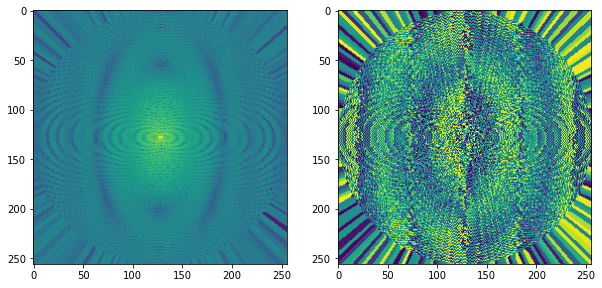

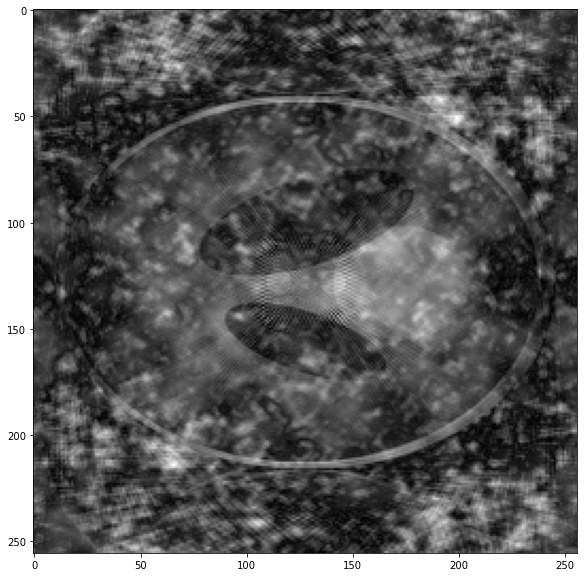

In [30]:
visualize_single_kspace(inter_k_space)
imshow(ifft(inter_k_space))

Wieso ist diese Art der Interpolation nicht besonders gut geeignet?

<span style="color:blue">(TODO - Schreiben Sie Ihre Antwort hier hin!) </span>

Am Rand gibt es keine Daten mehr und daher ist der Nächste Nachbar sehr weit entfernt. Dadurch haben die höheren Frequenzen die falschen Werte und es kommt zu diesen Artefakten.


## Aufgabe 2 - NUFFT

Sie werden nun die NUFFT mit einen Kaiser-Bessel-Kernel implementieren. Der Parameter $\beta$ soll wie folgt gewählt sein:

In [31]:
beta = np.pi * 3.2**0.5

Die Breite des Kernels soll 4 sein:

In [32]:
kernel_width = 4

Da die Berechnung des Kaiser-Bessel-Fensters für jeden Punkt sehr aufwendig ist, wird meist das Fenster "vorgesamplet". In der eigentlichen Berechnung wird dann einfach das Sample genommen, was am nächsten dran ist.

In [33]:
kb = np.kaiser(1024*kernel_width, beta)

Da die Fensterfunktion symmetrisch ist, brauchen wir nur eine Hälfte. Außerdem muss die Funktion am Rand 0 sein

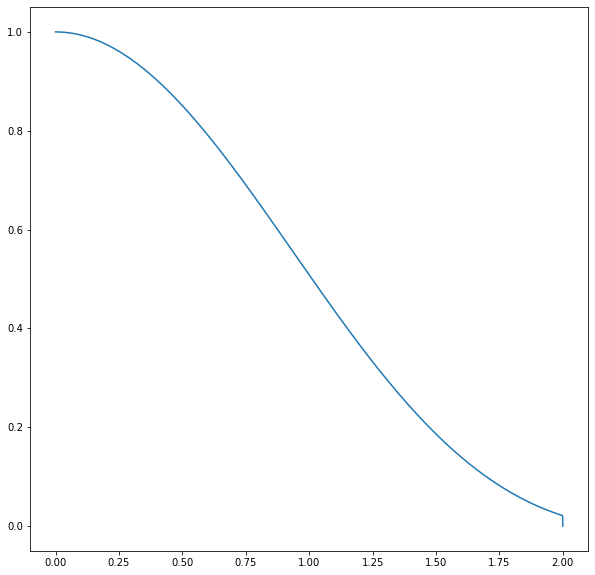

In [34]:
kb_half = kb[int(len(kb)/2):]
kb_half[-1] = 0
plt.plot(np.linspace(0, 0.5, len(kb_half))*kernel_width, kb_half)

Implementieren Sie nun die NUFFT mit dem Kaiser-Bessel-Kernel und visualisieren Sie das Ergebnis

Tipp 1: Denken Sie an die iFFT nach dem Gridding
Tipp 2: Nutzen Sie die gleiche Dichtekompensation für die k-Raum Daten wie im vorherigen Notebook. Ansonsten wird das Bild wieder verwaschen aussehen.

In [75]:
grid = np.mgrid[-128:128:1, -128:128:1]
dist = np.linalg.norm(trajectory - grid, axis=0)

print(dist.shape)
inter_k_space = np.zeros((256, 256), dtype=complex)



for i in range(256):
    for j in range(256):
        # coord = np.array([i - 128, j - 128])
        # inter_k_space[i, j] = radial_kspace[dist < 2] * kb_half[dist[dist < 2].astype(np.int32)]
        coord = trajectory[:, i, j]
        coord = coord.astype(np.int32)
        coords = np.reshape(np.concatenate([np.arange(coord[0] - 1, coord[0] + 3), np.arange(coord[1] - 1, coord[1] + 3)]), (2, 4))
        print(coord)
        print(coords)
        print(grid[max(coord[0] - 1, -128): min(coord[0] + 3, 127), coord[1] - 1: coord[1] + 3])
        break
        # dist = np.linalg.norm(grid - coord[:,None, None], axis=0)
        # for k in range(coord[0] - 1, coord[0] + 3):
        #     for l in range(coord[1] - 1, coord[1] + 2):
        #         # dist = np.linalg.norm(trajectory[:, i, j] - (k, l))
        #         pass


(256, 256)
[-128    0]
[[-129 -128 -127 -126]
 [  -1    0    1    2]]
[]
[-127    0]
[[-128 -127 -126 -125]
 [  -1    0    1    2]]
[]
[-126    0]
[[-127 -126 -125 -124]
 [  -1    0    1    2]]
[]
[-125    0]
[[-126 -125 -124 -123]
 [  -1    0    1    2]]
[]
[-124    0]
[[-125 -124 -123 -122]
 [  -1    0    1    2]]
[]
[-123    0]
[[-124 -123 -122 -121]
 [  -1    0    1    2]]
[]
[-122    0]
[[-123 -122 -121 -120]
 [  -1    0    1    2]]
[]
[-121    0]
[[-122 -121 -120 -119]
 [  -1    0    1    2]]
[]
[-120    0]
[[-121 -120 -119 -118]
 [  -1    0    1    2]]
[]
[-119    0]
[[-120 -119 -118 -117]
 [  -1    0    1    2]]
[]
[-118    0]
[[-119 -118 -117 -116]
 [  -1    0    1    2]]
[]
[-117    0]
[[-118 -117 -116 -115]
 [  -1    0    1    2]]
[]
[-116    0]
[[-117 -116 -115 -114]
 [  -1    0    1    2]]
[]
[-115    0]
[[-116 -115 -114 -113]
 [  -1    0    1    2]]
[]
[-114    0]
[[-115 -114 -113 -112]
 [  -1    0    1    2]]
[]
[-113    0]
[[-114 -113 -112 -111]
 [  -1    0    1    2]]


## Aufgabe 3 - Deapodisation

Wenden Sie nun eine Deapodisation an, um das rekonstruierte Bild zu verbessern

Tipp 1: Die iFT des Kaiser-Bessel-Kernels finden Sie in den Folien
Tipp 2: $\frac{1}{I_0(\beta)}$ ist nur ein konstanter Faktor und kann daher weggelassen werden
Tipp 3: Der Wertebereich der Koordinaten im Bildraum ist nach wie vor [-0.5, 0.5]